In [1]:
# Standard libraries
import re
import csv
import nltk
import spacy
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 




In [2]:
# Style
import matplotlib.style as style 
sns.set(font_scale=1.5)
style.use('seaborn-pastel')
style.use('seaborn-poster')
from PIL import Image
from wordcloud import WordCloud

In [3]:
# Preprocessing
import en_core_web_sm
from collections import Counter
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords, wordnet  
from sklearn.feature_extraction.text import CountVectorizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.model_selection import train_test_split, RandomizedSearchCV

In [4]:
# Building classification models
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [5]:
# Model evaluation
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [6]:
#importing thr data
tweet_data= pd.read_csv('/content/twitter_sentiment_data.csv')
tweet_data

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153
...,...,...,...
43938,1,"Dear @realDonaldTrump,\nYeah right. Human Medi...",791307031919550464
43939,1,What will your respective parties do to preven...,791316857403936768
43940,2,RT @MikkiL: UN Poll Shows Climate Change Is th...,791357509101621249
43941,0,RT @taehbeingextra: i still can$q$t believe th...,791390042136641537


In [7]:
#drop the sentiment value 2
tweet_data.drop(tweet_data[tweet_data['sentiment'] == 2].index , inplace = True)
tweet_data.head(10)

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
5,0,Unamshow awache kujinga na iko global warming ...,793125429418815489
8,0,RT @AmericanIndian8: Leonardo DiCaprio's clima...,793127097854197761
9,1,#BeforeTheFlood Watch #BeforeTheFlood right he...,793127346106753028
10,1,RT @DrDeJarnett: It's vital that the public he...,793127915269480448
11,1,"Bangladesh did not cause climate change, so th...",793129746003615745
12,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793129922210492417


In [8]:
print(tweet_data.shape)

(34667, 3)


In [9]:
print(f"No of Duplicated tweets in data: {tweet_data.duplicated('message').sum()}")

No of Duplicated tweets in data: 2705


Lets Create a copy of data by replacing sentiment values with str and removing the duplicate values

In [10]:
tweet_data.copy()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
5,0,Unamshow awache kujinga na iko global warming ...,793125429418815489
...,...,...,...
43936,1,#AikBaatSuniThi \nGlobal warming has negative ...,791293803877502976
43938,1,"Dear @realDonaldTrump,\nYeah right. Human Medi...",791307031919550464
43939,1,What will your respective parties do to preven...,791316857403936768
43941,0,RT @taehbeingextra: i still can$q$t believe th...,791390042136641537


In [11]:
def update(df):
  df = tweet_data.copy()
  sentiment = df['sentiment']
  word_sentiment = []

  for i in sentiment :
        if i == 1 :
          word_sentiment.append('Positive')
        elif i==0 :
          word_sentiment.append('Neutral')
        else:
          word_sentiment.append('Negative')
     
  df['sentiment'] = word_sentiment   
  return df

df = update(tweet_data)
df.head()

,sentiment,message,tweetid
0,Negative,@tiniebeany climate change is an interesting h...,792927353886371840
1,Positive,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,Positive,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,Positive,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
5,Neutral,Unamshow awache kujinga na iko global warming ...,793125429418815489


In [12]:
#Extracting the hashtags
def hashtag(tweet):
   hashtags = []
    
   for i in tweet:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
        
   hashtags=sum(hashtags, [])
   freq= nltk.FreqDist(hashtags)
    
   hashtag = pd.DataFrame({'hashtag': list(freq.keys()),'count': list(freq.values())})
   hashtag = hashtag.nlargest(15, columns="count")

   return hashtag

# Extracting the hashtags from tweets in each class
Positive = hashtag(df['message'][df['sentiment'] == 'Positive'])
Negative = hashtag(df['message'][df['sentiment'] == 'Negative'])
Neutral = hashtag(df['message'][df['sentiment'] == 'Neutral'])

In [13]:
Positive.head()

,hashtag,count
2,climate,504
35,climatechange,272
0,BeforeTheFlood,233
70,ActOnClimate,143
20,ParisAgreement,105


In [14]:
Negative.head()

,hashtag,count
2,tcot,55
44,MAGA,25
9,climate,23
19,Trump,19
22,climatechange,19


In [15]:
Neutral.head()

,hashtag,count
21,climate,52
27,climatechange,34
18,Trump,19
26,ClimateChange,16
28,auspol,13


Tweet messages Cleaning

In [16]:
def TweetCleaner(tweet):
  #Remove hashtags
  tweet = re.sub(r'#\w*', '', tweet)

  #Convert everything to lowercase
  tweet = tweet.lower() 

  # Remove mentions   
  tweet = re.sub('@[\w]*','',tweet) 

  #Remove numbers
  tweet = re.sub(r'\d+', '', tweet)

  # Remove url's
  tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    
  # Remove punctuation
  tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', tweet)
    
  # Remove extra whitespace
  tweet = re.sub(r'\s\s+', ' ', tweet)
  tweet=re.sub(r'\brt\b', ' ', tweet)
  tweet = re.sub(r"U+FFFD ", ' ', tweet)
  tweet = tweet.lstrip(' ')  
  return tweet

# Clean the tweets in the message column
df['message'] = df['message'].apply(TweetCleaner)
df.head()


,sentiment,message,tweetid
0,Negative,climate change is an interesting hustle as it ...,792927353886371840
1,Positive,watch right here as travels the world to tackl...,793124211518832641
2,Positive,fabulous leonardo s film on change is brillian...,793124402388832256
3,Positive,just watched this amazing documentary by leona...,793124635873275904
5,Neutral,unamshow awache kujinga na iko global warming,793125429418815489


In [17]:
import emoji
import emoji
# Loading dictionary of smilies
#def load_dict_smileys():
def load_dict_smileys():
    return{
 ':-)':'smiley',
 ':)': 'smiley',
 ':D': 'smiley',
 'xD': 'smiley',
 ':’)': 'smiley',
 ':’D': 'smiley',
 ':3': 'smiley',
 ':]': 'smiley',
 ':^)':'smiley', 
 ':-]': 'smiley',
 ':-3': 'smiley',
 ':->': 'smiley',
 ':))': 'smiley',
 '8-)': 'cool',
 '8)': 'cool',
 '8-D': 'cool',
 'B)': 'cool',
 'BD': 'cool',
 ':-}': 'smiley',
 ':>': 'smiley',
 ':}': 'smiley',
 ':o)': 'smiley',
 ':c)': 'smiley',
 '=)': 'smiley',
 '=D': 'smiley',
 '=]': 'smiley',
 ':-D': 'smiley',
 'XD': 'smiley',
 ':o': 'surprised',
 ':O': 'surprised',
 '=o': 'surprised',
 '=O': 'surprised',
 ':0': 'surprised',
 ':(': 'sad',
 ':C': 'sad',
 ':c': 'sad',
 '=(': 'sad',
 '=c': 'sad',
 '=C': 'sad',
 ':-(': 'sad',
 ':-c': 'sad',
 ':-C': 'sad',
 ':-<': 'sad',
 ':<': 'sad',
 ':[':'sad',
 ':{': 'sad',
 ':’(': 'sad',
 ':P': 'playful',
 ':p': 'playful',
 'xP': 'playful',
 'XP': 'playful',
 '=P': 'playful',
 '=p': 'playful',
 'xp': 'playful',
 'xb': 'playful',
 '❤': 'love',
 '</3': 'sad',
 ':/': 'worried',
 ':-/': 'worried'
    }

# Removing smilies and emojis
def remove_emoticons(tweet):
    smilies = load_dict_smileys()
    split_tweet = tweet.split(" ")
    for key,val in smilies.items():
        if key in tweet:
            new_tweet = tweet.replace(key, val)
            tweet = new_tweet
            tweet = emoji.demojize(tweet)
            tweet = ' '.join(tweet.split())
            return tweet
df['tweet_no_emoji'] = df['message'].apply(lambda x: remove_emoticons(x))
df

,sentiment,message,tweetid,tweet_no_emoji
0,Negative,climate change is an interesting hustle as it ...,792927353886371840,None
1,Positive,watch right here as travels the world to tackl...,793124211518832641,None
2,Positive,fabulous leonardo s film on change is brillian...,793124402388832256,None
3,Positive,just watched this amazing documentary by leona...,793124635873275904,None
5,Neutral,unamshow awache kujinga na iko global warming,793125429418815489,None
...,...,...,...,...
43936,Positive,global warming has negative effect on the melt...,791293803877502976,None
43938,Positive,dear yeah right human mediated climate change ...,791307031919550464,None
43939,Positive,what will your respective parties do to preven...,791316857403936768,None
43941,Neutral,i still can q t believe this gif of taehyung s...,791390042136641537,None


In [18]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [19]:
df

,sentiment,message,tweetid,tweet_no_emoji
0,Negative,climate change is an interesting hustle as it ...,792927353886371840,None
1,Positive,watch right here as travels the world to tackl...,793124211518832641,None
2,Positive,fabulous leonardo s film on change is brillian...,793124402388832256,None
3,Positive,just watched this amazing documentary by leona...,793124635873275904,None
5,Neutral,unamshow awache kujinga na iko global warming,793125429418815489,None
...,...,...,...,...
43936,Positive,global warming has negative effect on the melt...,791293803877502976,None
43938,Positive,dear yeah right human mediated climate change ...,791307031919550464,None
43939,Positive,what will your respective parties do to preven...,791316857403936768,None
43941,Neutral,i still can q t believe this gif of taehyung s...,791390042136641537,None


In [20]:
stopwords_list=stopwords.words('english')
from nltk.corpus import stopwords
" , ".join(stopwords.words('english'))

"i , me , my , myself , we , our , ours , ourselves , you , you're , you've , you'll , you'd , your , yours , yourself , yourselves , he , him , his , himself , she , she's , her , hers , herself , it , it's , its , itself , they , them , their , theirs , themselves , what , which , who , whom , this , that , that'll , these , those , am , is , are , was , were , be , been , being , have , has , had , having , do , does , did , doing , a , an , the , and , but , if , or , because , as , until , while , of , at , by , for , with , about , against , between , into , through , during , before , after , above , below , to , from , up , down , in , out , on , off , over , under , again , further , then , once , here , there , when , where , why , how , all , any , both , each , few , more , most , other , some , such , no , nor , not , only , own , same , so , than , too , very , s , t , can , will , just , don , don't , should , should've , now , d , ll , m , o , re , ve , y , ain , aren ,

In [21]:
Stop_Words=set(stopwords.words('english'))
def cleaning_stopwords(message):
    return " ".join([word for word in str(message).split()if word not in Stop_Words])
df['message'] = df['message'].apply(cleaning_stopwords)
df.head(10)

,sentiment,message,tweetid,tweet_no_emoji
0,Negative,climate change interesting hustle global warmi...,792927353886371840,None
1,Positive,watch right travels world tackle climate chang...,793124211518832641,None
2,Positive,fabulous leonardo film change brilliant watch via,793124402388832256,None
3,Positive,watched amazing documentary leonardodicaprio c...,793124635873275904,None
5,Neutral,unamshow awache kujinga na iko global warming,793125429418815489,None
8,Neutral,leonardo dicaprio climate change documentary f...,793127097854197761,None
9,Positive,watch right travels world tackle climate change,793127346106753028,None
10,Positive,vital public health community addresses climat...,793127915269480448,None
11,Positive,bangladesh cause climate change country need ã...,793129746003615745,None
12,Positive,watch right travels world tackle climate chang...,793129922210492417,None


Stemming

In [22]:
st=nltk.PorterStemmer()
def stemming_on_text(df):
    message=[st.stem(word) for word in df]
    return df
df['message'] = df['message'].apply(stemming_on_text)
df.head()

,sentiment,message,tweetid,tweet_no_emoji
0,Negative,climate change interesting hustle global warmi...,792927353886371840,None
1,Positive,watch right travels world tackle climate chang...,793124211518832641,None
2,Positive,fabulous leonardo film change brilliant watch via,793124402388832256,None
3,Positive,watched amazing documentary leonardodicaprio c...,793124635873275904,None
5,Neutral,unamshow awache kujinga na iko global warming,793125429418815489,None


Lemmatization

In [23]:
lm=nltk.WordNetLemmatizer()
def lemmatizer_on_text(df):
    message=[lm.lemmatize(word) for word in df]
    return df
df['message'] = df['message'].apply(lemmatizer_on_text)
df.head()

,sentiment,message,tweetid,tweet_no_emoji
0,Negative,climate change interesting hustle global warmi...,792927353886371840,None
1,Positive,watch right travels world tackle climate chang...,793124211518832641,None
2,Positive,fabulous leonardo film change brilliant watch via,793124402388832256,None
3,Positive,watched amazing documentary leonardodicaprio c...,793124635873275904,None
5,Neutral,unamshow awache kujinga na iko global warming,793125429418815489,None


In [24]:
def word_count(sentence):
    return len(sentence.split())
    
df['word count'] = df['message'].apply(word_count)
df.head()

,sentiment,message,tweetid,tweet_no_emoji,word count
0,Negative,climate change interesting hustle global warmi...,792927353886371840,None,12
1,Positive,watch right travels world tackle climate chang...,793124211518832641,None,8
2,Positive,fabulous leonardo film change brilliant watch via,793124402388832256,None,7
3,Positive,watched amazing documentary leonardodicaprio c...,793124635873275904,None,8
5,Neutral,unamshow awache kujinga na iko global warming,793125429418815489,None,7


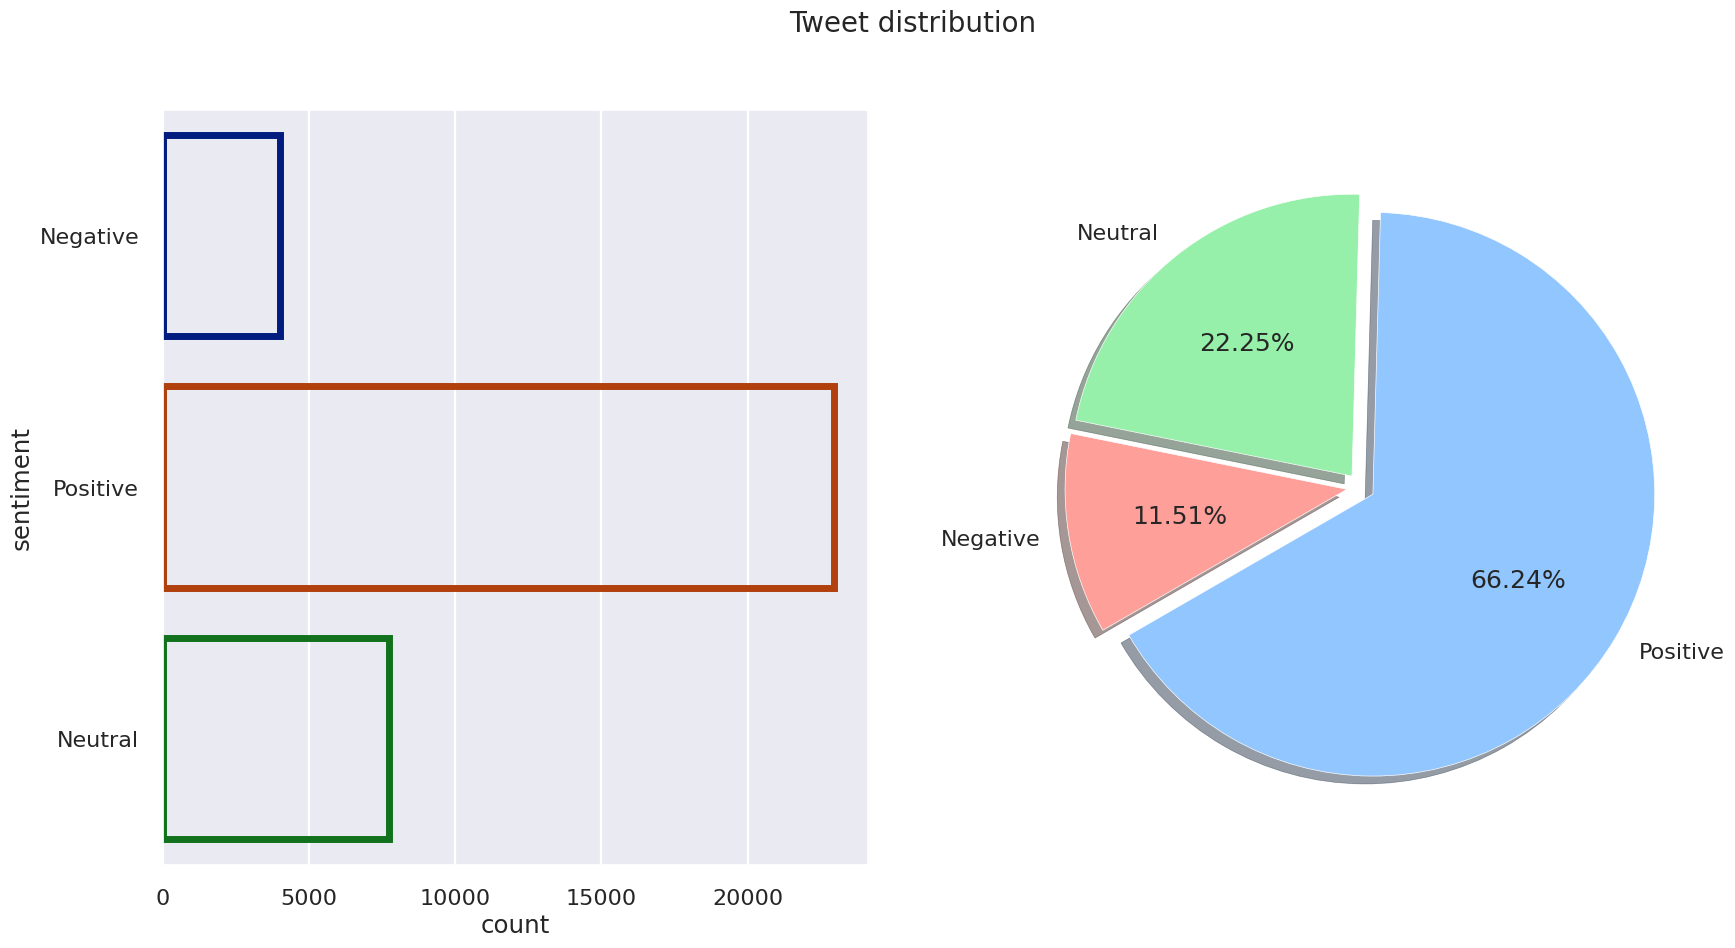

In [25]:
style.use('seaborn-pastel')

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 10), dpi=100)
sns.countplot(y=df['sentiment'], facecolor=(0, 0, 0, 0), linewidth=5, edgecolor=sns.color_palette("dark", 3), ax=axes[0])
labels=['Positive', 'Neutral', 'Negative']
axes[1].pie(df['sentiment'].value_counts(), labels=labels, shadow=True, autopct='%1.2f%%', startangle=210, explode = (0.05, 0.05, 0.05))
fig.suptitle('Tweet distribution', fontsize=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


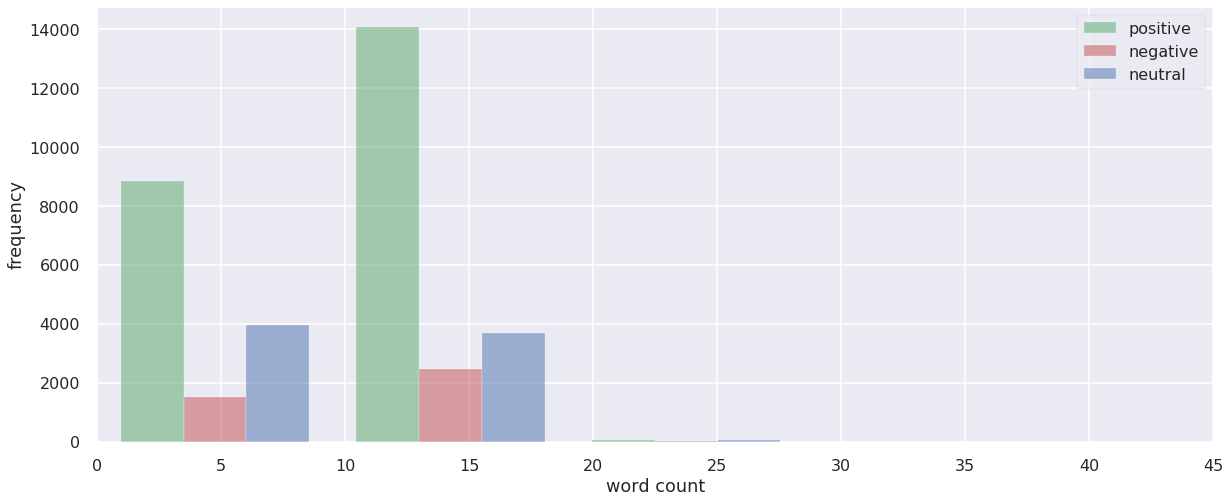

In [26]:
x = df['word count'][df.sentiment == 'Positive']
y = df['word count'][df.sentiment == 'Negative']
z = df['word count'][df.sentiment == 'Neutral']

plt.figure(figsize=(20,8))
plt.xlim(0,45)
plt.xlabel('word count')
plt.ylabel('frequency')
g = plt.hist([x, y,z], color=['g','r','b'], alpha=0.5, label=['positive','negative','neutral'])
plt.legend(loc='upper right')  
plt.show()

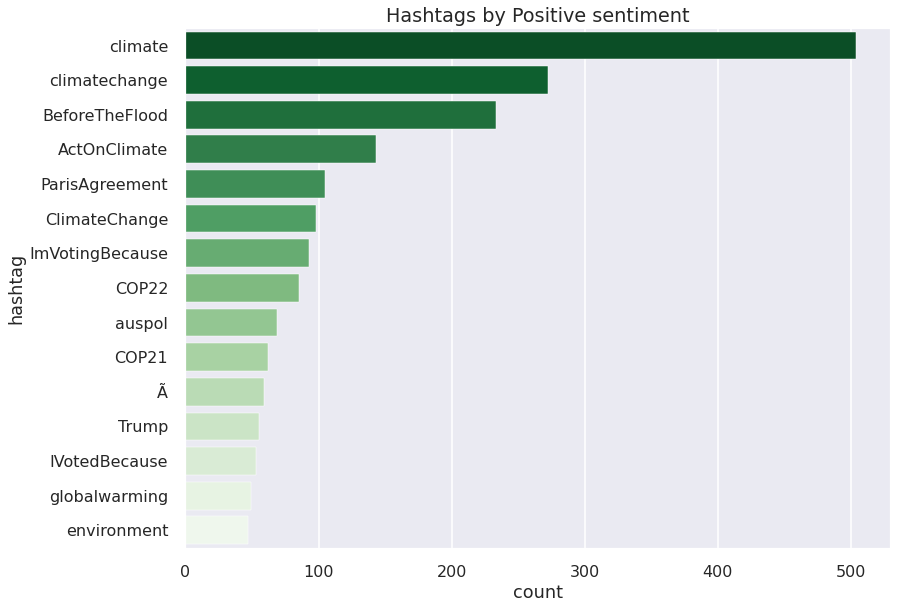

In [27]:
sns.barplot(data=Positive,y=Positive['hashtag'], x=Positive['count'], palette=("Greens_r") )
plt.title('Hashtags by Positive sentiment')
plt.tight_layout()

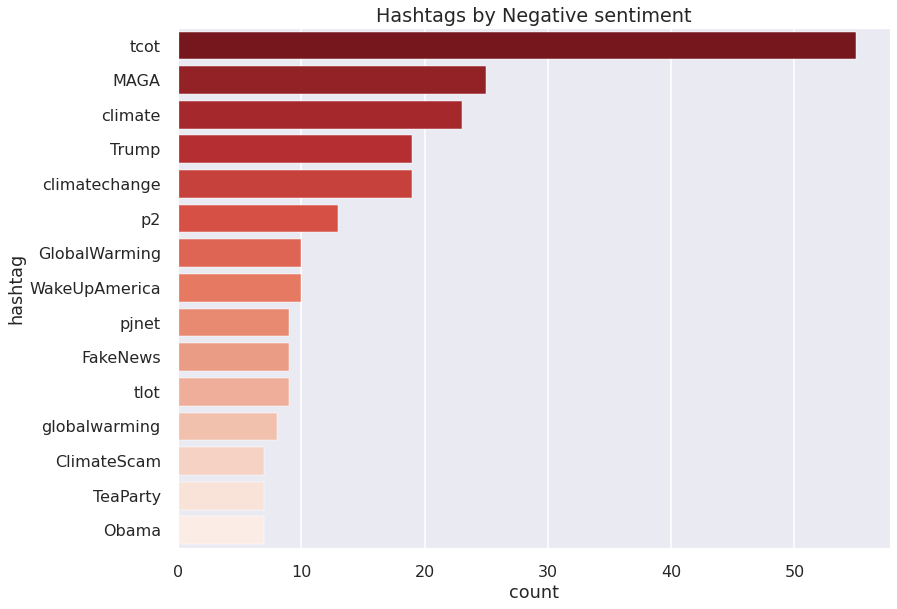

In [28]:
sns.barplot(data=Negative,y=Negative['hashtag'], x=Negative['count'], palette=("Reds_r") )
plt.title('Hashtags by Negative sentiment')
plt.tight_layout()

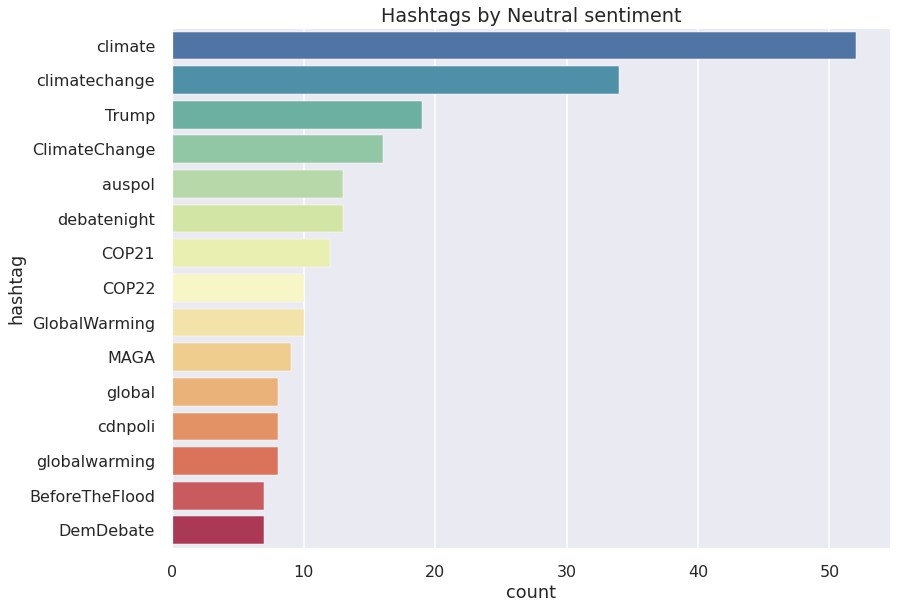

In [29]:
sns.barplot(data=Neutral,y=Neutral['hashtag'], x=Neutral['count'], palette=("Spectral_r") )
plt.title('Hashtags by Neutral sentiment')
plt.tight_layout()